In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [146]:
# Goal: Try to preduct Aramco stock price using historical data using a Time Series Analyis Model using LSTM.
# LSTM (Long-Short Term Memory) is a type of RNN (Recurrent Neural Network) designed to better handle sequences of data,
# especially when long term dependencies are important.

# Dataset Exploration

## Dataset Overview

In [147]:
df = pd.read_csv('saudi_aramco_data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-11,29.090908,29.090908,29.090908,29.090908,24.556959,38289394
1,2019-12-12,31.983471,31.983471,29.752066,30.413223,25.673187,505692621
2,2019-12-15,30.661158,30.991735,30.413223,30.909090,26.091770,98349281
3,2019-12-16,30.991735,31.487602,30.991735,31.404959,26.510353,105973907
4,2019-12-17,31.446280,31.528925,30.991735,31.198347,26.335951,142672245


## Basic Statistics

In [148]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1.164000e+03
mean,30.502389,30.685119,30.314931,30.505042,28.200972,1.042249e+07
std,2.769039,2.801027,2.715085,2.756249,3.361246,2.646719e+07
min,22.314049,23.388430,22.314049,22.975206,19.394417,0.000000e+00
25%,28.836777,28.925619,28.680785,28.818180,25.978118,3.853885e+06
50%,29.628099,29.793388,29.504131,29.669420,27.945249,6.453034e+06
75%,32.349998,32.560226,32.200001,32.400002,31.083448,1.174389e+07
max,38.636364,39.409088,38.363636,38.636364,35.543354,6.562831e+08


## Checking for NULL values

In [149]:
# There is no null data in the data set
df.isnull().values.any()

np.False_

In [150]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


## Check for duplicated values

In [151]:
df.duplicated().sum()

np.int64(0)

## Convert date to proper format

In [153]:
df['Date'] = pd.to_datetime(df['Date'])

# Saudi Aramco Stock Price and Volume Trends (2019–2024)

In [154]:
for i in df.columns[1:7]:
    fig = px.line(df, y=i, x=df.columns[0])
    fig.show()


### Stock Market Anomaly Detection using Z-Score

For detecting anomalies in stock market data, the Z-score method is a simple and effective approach. It identifies data points that deviate significantly from the mean, measured in standard deviations. Typically, a Z-score beyond ±2 indicates an anomaly, meaning the point lies more than two standard deviations away from the average.

- **Price Anomalies (Red):** Highlight significant deviations from typical price ranges, often triggered by unexpected news, earnings reports, or sudden market shifts.
- **Volume Anomalies (Orange):** Indicate unusually high or low trading activity compared to normal levels, commonly driven by major events, announcements, or changes in market sentiment.

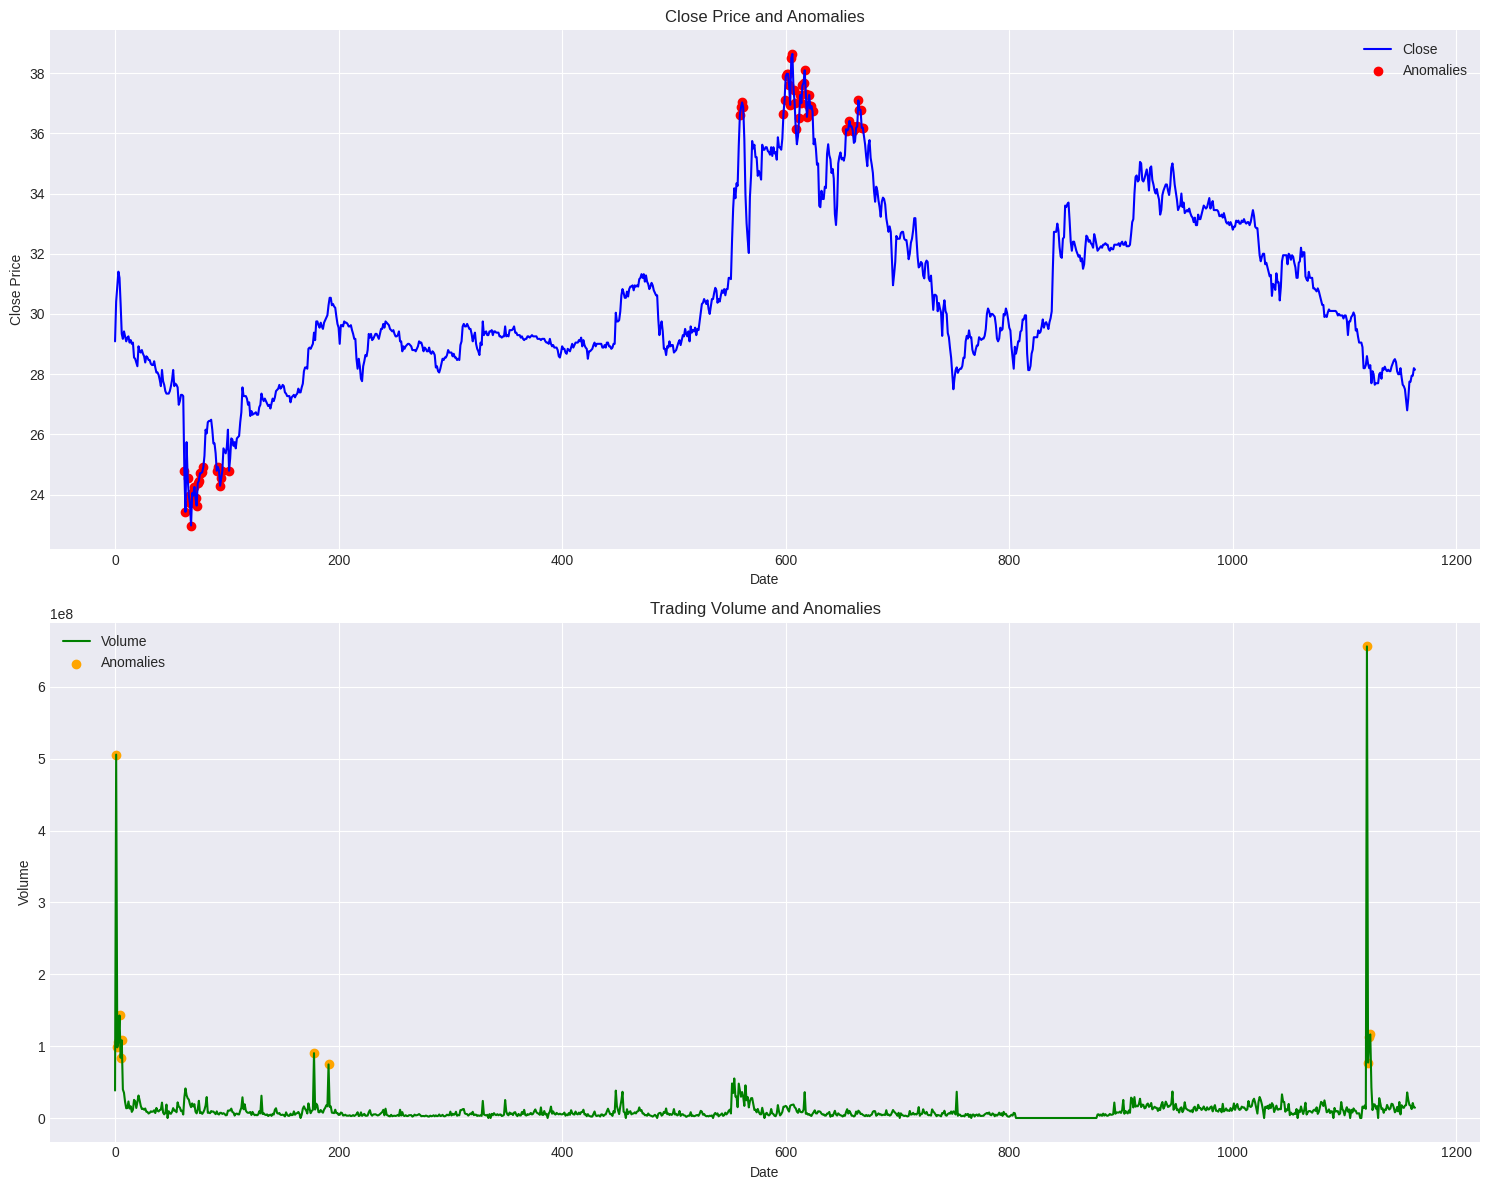

In [155]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()


close_anomalies = detect_anomalies(df, 'Close')
volume_anomalies = detect_anomalies(df, 'Volume')
# use concat instead of append
anomalies_close = pd.concat([anomalies_close, close_anomalies])
anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

def plot_anomalies(df, anomalies_adj_close, anomalies_volume):
    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(df.index, df['Close'], label='Close', color='blue')
    ax1.scatter(close_anomalies.index, close_anomalies['Close'], color='red', label='Anomalies')
    ax1.set_title(f'Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price')
    ax1.legend()

    # volume
    ax2.plot(df.index, df['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_anomalies(df, anomalies_close, anomalies_volume)

## Calculating Risk Indicator Using Mean Absolute Z-Score

### 📈 Moderate Price Volatility
The stock experienced some price fluctuations, but nothing excessively volatile. This indicates a **moderate level of risk** in price movements, with deviations occurring occasionally but remaining within a manageable range for investors.


### 📊 Significant Volume Irregularities
Trading volume showed **frequent and substantial anomalies**, reflecting strong market reactions. These irregularities suggest heightened sensitivity to external factors such as news events, earnings announcements, or shifts in investor sentiment, potentially driven by speculative behavior.

### ⚠️ Overall Risk Assessment
The combined risk profile points to a **high overall market risk**, primarily due to significant volume fluctuations. Traders and investors should exercise caution, particularly during periods of increased market activity or unexpected events that could trigger liquidity concerns or abrupt market movements.

In [156]:
# Calculate the mean absolute Z-score for the stock as a risk indicator
price_close_risk = anomalies_close['Z-score'].abs().mean()
volume_risk = anomalies_volume['Z-score'].abs().mean()

# Display individual risk scores
print(f"📈 Price Risk (Mean Absolute Z-Score): {price_close_risk:.4f}")
print(f"📊 Volume Risk (Mean Absolute Z-Score): {volume_risk:.4f}")

# Combine the risk scores from both price and volume anomalies
total_risk = price_close_risk + volume_risk

# Display total risk score
print(f"⚠️ Total Combined Risk Score: {total_risk:.4f}")

📈 Price Risk (Mean Absolute Z-Score): 2.3022
📊 Volume Risk (Mean Absolute Z-Score): 6.4478
⚠️ Total Combined Risk Score: 8.7499


In [157]:
# Frequency of Significant Anomalies (High Z-Score)
# Count how often the stock's price and volume deviate significantly (|Z-score| > 2)

price_spikes = (anomalies_close['Z-score'].abs() > 2).sum()
volume_spikes = (anomalies_volume['Z-score'].abs() > 2).sum()

print(f"📈 Number of Significant Price Spikes (|Z-score| > 2): {price_spikes}")
print(f"📊 Number of Significant Volume Spikes (|Z-score| > 2): {volume_spikes}")

📈 Number of Significant Price Spikes (|Z-score| > 2): 67
📊 Number of Significant Volume Spikes (|Z-score| > 2): 12


In [158]:
# Create a Risk Profile Summary
risk_profile = {
    "Mean Price Risk (Z-score)": round(price_close_risk, 4),
    "Mean Volume Risk (Z-score)": round(volume_risk, 4),
    "Total Combined Risk": round(total_risk, 4),
    "Significant Price Spikes (|Z| > 2)": price_spikes,
    "Significant Volume Spikes (|Z| > 2)": volume_spikes,
}

print("📊 Risk Profile Summary")
for key, value in risk_profile.items():
    print(f"- {key}: {value}")

📊 Risk Profile Summary
- Mean Price Risk (Z-score): 2.3022
- Mean Volume Risk (Z-score): 6.4478
- Total Combined Risk: 8.7499
- Significant Price Spikes (|Z| > 2): 67
- Significant Volume Spikes (|Z| > 2): 12


# Calculating Technical Indicators: SMA, MACD, and RSI for Trend and Momentum Analysis

In [159]:
from ta.trend import SMAIndicator, MACD
from ta.momentum import RSIIndicator


# ----- SMA -----
sma = SMAIndicator(close=df['Close'], window=20)
df['SMA_20'] = sma.sma_indicator()

# ----- MACD -----
macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

# ----- RSI -----
rsi = RSIIndicator(close=df['Close'], window=14)
df['RSI_14'] = rsi.rsi()

df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,MACD,MACD_Signal,MACD_diff,RSI_14
1159,2024-08-08,27.850000,28.000000,27.700001,27.750000,27.750000,17357744,27.8875,-0.240079,-0.224831,-0.015249,47.405768
1160,2024-08-11,28.000000,28.000000,27.850000,27.950001,27.950001,12398587,27.8800,-0.196393,-0.219143,0.022750,51.243727
1161,2024-08-12,28.000000,28.049999,27.850000,27.950001,27.950001,20835997,27.8725,-0.159928,-0.207300,0.047372,51.243727
1162,2024-08-13,28.000000,28.200001,27.950001,28.200001,28.200001,14572319,27.8700,-0.109593,-0.187759,0.078166,55.908152
1163,2024-08-14,28.200001,28.350000,28.150000,28.150000,28.150000,14448655,27.8600,-0.072897,-0.164786,0.091890,54.779372


## Visualizing Trading Signals: SMA Crossovers, MACD Signals, and RSI Levels

## 📊 Summary of Technical Indicator Analysis

The following insights were derived from the visualization of **SMA**, **MACD**, and **RSI** signals:

### 1. 📈 Price & SMA Crossovers
- Frequent **bullish** and **bearish crossovers** between the stock price and the 20-day SMA indicate regular short-term trend reversals.
- This suggests a **range-bound** or **choppy market**, where prices oscillate around the moving average.
- Traders should be cautious of **false signals** in sideways markets.

---

### 2. 📊 MACD Crossover Signals
- Multiple **MACD crossovers** highlight frequent momentum shifts.
- Clear signals appear during strong price movements, but during low-momentum periods, the MACD generates **frequent crossovers**, increasing the risk of **whipsaws**.
- MACD is more reliable in trending markets than in consolidating phases.

---

### 3. ⚠️ RSI Overbought/Oversold Levels
- The RSI frequently reaches **overbought (>70)** and **oversold (<30)** zones, effectively signaling potential reversals.
- These signals capture **extremes in market sentiment**, but RSI can remain extended in strong trends, so it should not be used in isolation.

---

### Overall Insights
- The stock demonstrates **moderate volatility** with frequent short-term trading signals.
- Indicators suggest opportunities for **active traders**, but also highlight the importance of avoiding false signals in non-trending markets.
- Combining signals from **SMA**, **MACD**, and **RSI** can improve reliability—confirmation across multiple indicators is recommended for better decision-making.


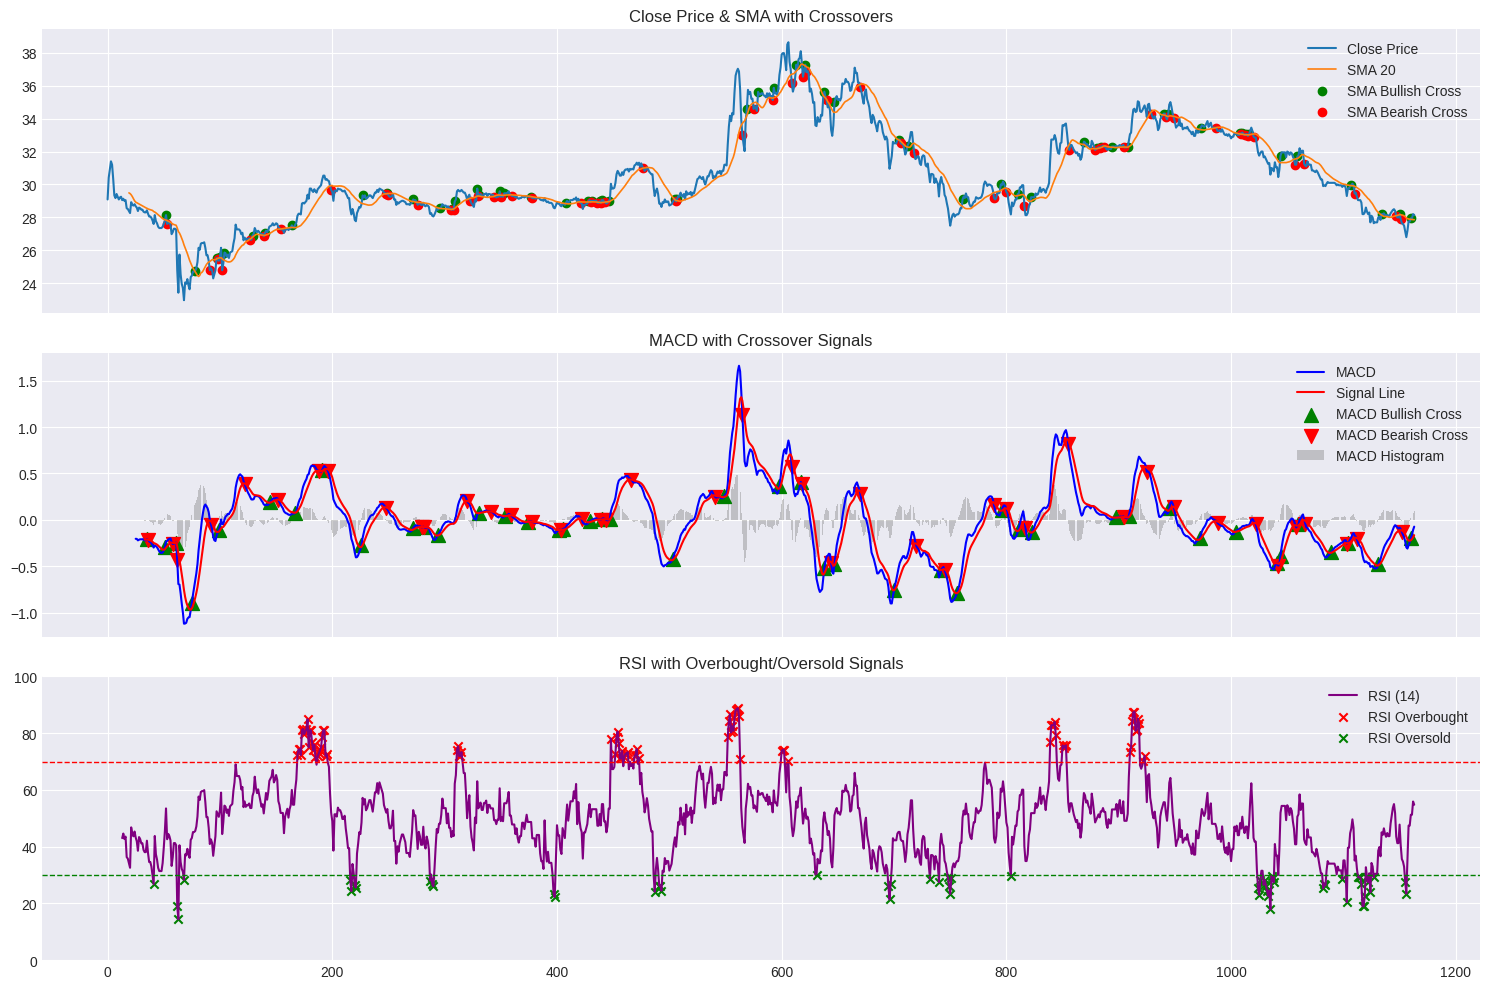

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# MACD Crossovers
macd_cross_up = (df['MACD'] > df['MACD_Signal']) & (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1))
macd_cross_down = (df['MACD'] < df['MACD_Signal']) & (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1))

# RSI overbought/oversold
rsi_overbought = df['RSI_14'] > 70
rsi_oversold = df['RSI_14'] < 30

# SMA Crossovers
sma_cross_up = (df['Close'] > df['SMA_20']) & (df['Close'].shift(1) <= df['SMA_20'].shift(1))
sma_cross_down = (df['Close'] < df['SMA_20']) & (df['Close'].shift(1) >= df['SMA_20'].shift(1))

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
plt.style.use('seaborn-v0_8-darkgrid')

# --- Price & SMA ---
ax1.plot(df.index, df['Close'], label='Close Price', linewidth=1.5)
ax1.plot(df.index, df['SMA_20'], label='SMA 20', linewidth=1.2)

# SMA crossover markers
ax1.scatter(df.index[sma_cross_up], df['Close'][sma_cross_up], marker='o', color='green', label='SMA Bullish Cross')
ax1.scatter(df.index[sma_cross_down], df['Close'][sma_cross_down], marker='o', color='red', label='SMA Bearish Cross')

ax1.set_title('Close Price & SMA with Crossovers')
ax1.legend()

# --- MACD ---
ax2.plot(df.index, df['MACD'], label='MACD', color='blue')
ax2.plot(df.index, df['MACD_Signal'], label='Signal Line', color='red')
ax2.bar(df.index, df['MACD_diff'], label='MACD Histogram', color='gray', alpha=0.4)

# MACD crossover markers
ax2.scatter(df.index[macd_cross_up], df['MACD'][macd_cross_up], marker='^', color='green', label='MACD Bullish Cross', s=100)
ax2.scatter(df.index[macd_cross_down], df['MACD'][macd_cross_down], marker='v', color='red', label='MACD Bearish Cross', s=100)

ax2.set_title('MACD with Crossover Signals')
ax2.legend()

# --- RSI ---
ax3.plot(df.index, df['RSI_14'], label='RSI (14)', color='purple')
ax3.axhline(70, color='red', linestyle='--', linewidth=1)
ax3.axhline(30, color='green', linestyle='--', linewidth=1)

# RSI signal markers
ax3.scatter(df.index[rsi_overbought], df['RSI_14'][rsi_overbought], marker='x', color='red', label='RSI Overbought')
ax3.scatter(df.index[rsi_oversold], df['RSI_14'][rsi_oversold], marker='x', color='green', label='RSI Oversold')

ax3.set_ylim(0, 100)
ax3.set_title('RSI with Overbought/Oversold Signals')
ax3.legend()

plt.tight_layout()
plt.show()

# Data Preprocessing

## Scaling Features

In [161]:
df = df[['Date', 'Close']]
df.set_index('Date', inplace=True)

close_prices = df[['Close']].values

# Normalize prices
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

## Creating Input Sequences and Train-Test Split for LSTM Models

In [162]:
# === Create sequences ===
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 50  # num_unrollings
X, y = create_sequences(scaled_prices, sequence_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Building and Compiling an LSTM Model for Time Series Forecasting

In [163]:
# === Build LSTM model ===
model = Sequential([
    LSTM(200, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(200, return_sequences=True),
    Dropout(0.2),
    LSTM(150),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 50, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 50, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 50, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 50, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 150)            │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,151 (2.64 MB)

 Trainable params: 693,151 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training the LSTM Model for Time Series Forecasting

In [164]:
# === Train ===
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - loss: 0.0443 - val_loss: 0.0042
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 264ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 260ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - loss: 0.0038 - val_loss: 0.0125
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - loss: 0.0090 - val_loss: 0.0016
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - loss: 0.0031 - val_loss: 0.0055
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20

# Predicting Stock Prices and Evaluating LSTM Model Performance

In [165]:
# === Predict ===
from sklearn.metrics import mean_squared_error, r2_score
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("MSE: ", mse)
print("r2: ", r2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step
MSE:  0.0006226054936973048
r2:  0.9656314004423603


# Visualizing LSTM Forecast vs Actual Stock Prices

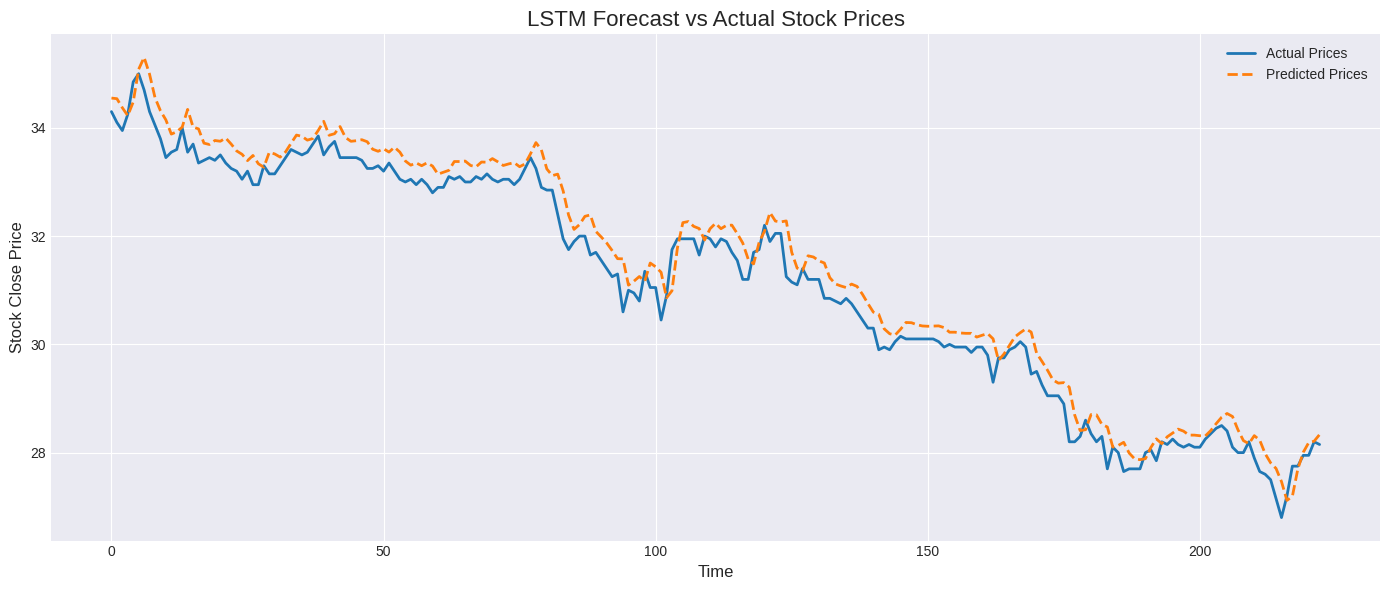

In [166]:
# === Visualizing LSTM Forecast vs Actual Prices ===
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='Actual Prices', linewidth=2)
plt.plot(predicted_prices, label='Predicted Prices', linewidth=2, linestyle='--')

plt.title('LSTM Forecast vs Actual Stock Prices', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Stock Close Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()